In [10]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from prophet import Prophet

# Model Persistence
import joblib
import pickle

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [11]:
# Generate sample data
np.random.seed(42)

# Generate date range (2000 days = ~5.5 years)
start_date = datetime(2019, 1, 1)
date_samples = [start_date + timedelta(days=i) for i in range(2000)]

# Create dataset
data = {
    'Date': date_samples,
    'Revenue': np.random.uniform(5000, 20000, 2000).round(2),
    'Marketing Spend (Google)': np.random.uniform(1000, 5000, 2000).round(2),
    'Marketing Spend (LinkedIn)': np.random.uniform(800, 4000, 2000).round(2),
    'Marketing Spend (Campus)': np.random.uniform(500, 3000, 2000).round(2),
    'Marketing Spend (Events)': np.random.uniform(600, 3500, 2000).round(2),
    'Operational Costs': np.random.uniform(3000, 8000, 2000).round(2),
    'Number of Enrollments': np.random.poisson(50, 2000),
    'Retention Rates': np.random.uniform(0.7, 0.95, 2000).round(2),
    'Seasonal Trends': np.random.choice(['High', 'Medium', 'Low'], 2000),
    'Conversions (Google)': np.random.poisson(10, 2000),
    'Conversions (LinkedIn)': np.random.poisson(8, 2000),
    'Conversions (Campus)': np.random.poisson(5, 2000),
    'Conversions (Events)': np.random.poisson(6, 2000),
    'Leads Generated (Google)': np.random.poisson(20, 2000),
    'Leads Generated (LinkedIn)': np.random.poisson(15, 2000),
    'Leads Generated (Campus)': np.random.poisson(10, 2000),
    'Leads Generated (Events)': np.random.poisson(12, 2000),
    'Customer Acquisition Cost (Google)': np.random.uniform(50, 200, 2000).round(2),
    'Customer Acquisition Cost (LinkedIn)': np.random.uniform(60, 220, 2000).round(2),
    'Customer Acquisition Cost (Campus)': np.random.uniform(70, 250, 2000).round(2),
    'Customer Acquisition Cost (Events)': np.random.uniform(65, 230, 2000).round(2),
    'Payment Terms': np.random.choice(['30 days', '60 days', '90 days'], 2000),
    'Fixed Costs': np.random.uniform(2000, 5000, 2000).round(2),
    'Variable Costs': np.random.uniform(1000, 3000, 2000).round(2),
    'Liabilities': np.random.uniform(1000, 5000, 2000).round(2)
}

df = pd.DataFrame(data)

# Add realistic patterns to revenue based on marketing spend and enrollments
df['Revenue'] = (
    df['Number of Enrollments'] * 150 +  # Base revenue from enrollments
    df['Marketing Spend (Google)'] * 2.5 +
    df['Marketing Spend (LinkedIn)'] * 2.0 +
    df['Marketing Spend (Campus)'] * 1.5 +
    df['Marketing Spend (Events)'] * 1.8 +
    np.random.normal(0, 1000, 2000)  # Add noise
).round(2)

# Save to CSV
df.to_csv('synthetic_dataset.csv', index=False)

print(f"Dataset Shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (2000, 26)

First 5 rows:


,Date,Revenue,Marketing Spend (Google),Marketing Spend (LinkedIn),Marketing Spend (Campus),Marketing Spend (Events),Operational Costs,Number of Enrollments,Retention Rates,Seasonal Trends,...,Leads Generated (Campus),Leads Generated (Events),Customer Acquisition Cost (Google),Customer Acquisition Cost (LinkedIn),Customer Acquisition Cost (Campus),Customer Acquisition Cost (Events),Payment Terms,Fixed Costs,Variable Costs,Liabilities
0,2019-01-01,24977.85,2046.82,2630.39,2120.64,2688.78,4868.20,53,0.91,Medium,...,17,10,57.65,169.96,204.27,81.91,90 days,3384.94,2765.40,1312.65
1,2019-01-02,23814.90,1987.92,3377.38,930.97,2593.12,4664.56,44,0.90,Medium,...,4,11,199.28,218.45,217.90,223.94,30 days,3125.36,1657.80,4098.34
2,2019-01-03,30708.40,4625.02,3232.51,2680.99,877.69,3880.77,51,0.92,Low,...,14,11,199.97,169.10,200.70,228.11,90 days,3941.42,2019.70,1098.32
3,2019-01-04,24294.77,1998.18,1292.48,2032.79,3275.46,6036.33,48,0.94,Medium,...,12,11,78.76,72.03,85.03,110.73,90 days,4166.33,1281.52,4680.17
4,2019-01-05,20139.84,2087.80,1277.60,893.01,2248.57,5383.12,49,0.81,Low,...,12,10,70.07,146.73,121.79,121.42,30 days,4305.80,2212.60,2483.33


In [12]:
# Basic statistics
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(df.info())
print("\n" + "=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)
print(df.describe())

# Check for missing values
print("\n" + "=" * 80)
print("MISSING VALUES")
print("=" * 80)
print(df.isnull().sum())

DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Date                                  2000 non-null   datetime64[ns]
 1   Revenue                               2000 non-null   float64       
 2   Marketing Spend (Google)              2000 non-null   float64       
 3   Marketing Spend (LinkedIn)            2000 non-null   float64       
 4   Marketing Spend (Campus)              2000 non-null   float64       
 5   Marketing Spend (Events)              2000 non-null   float64       
 6   Operational Costs                     2000 non-null   float64       
 7   Number of Enrollments                 2000 non-null   int32         
 8   Retention Rates                       2000 non-null   float64       
 9   Seasonal Trends                       2000 non-null   obj

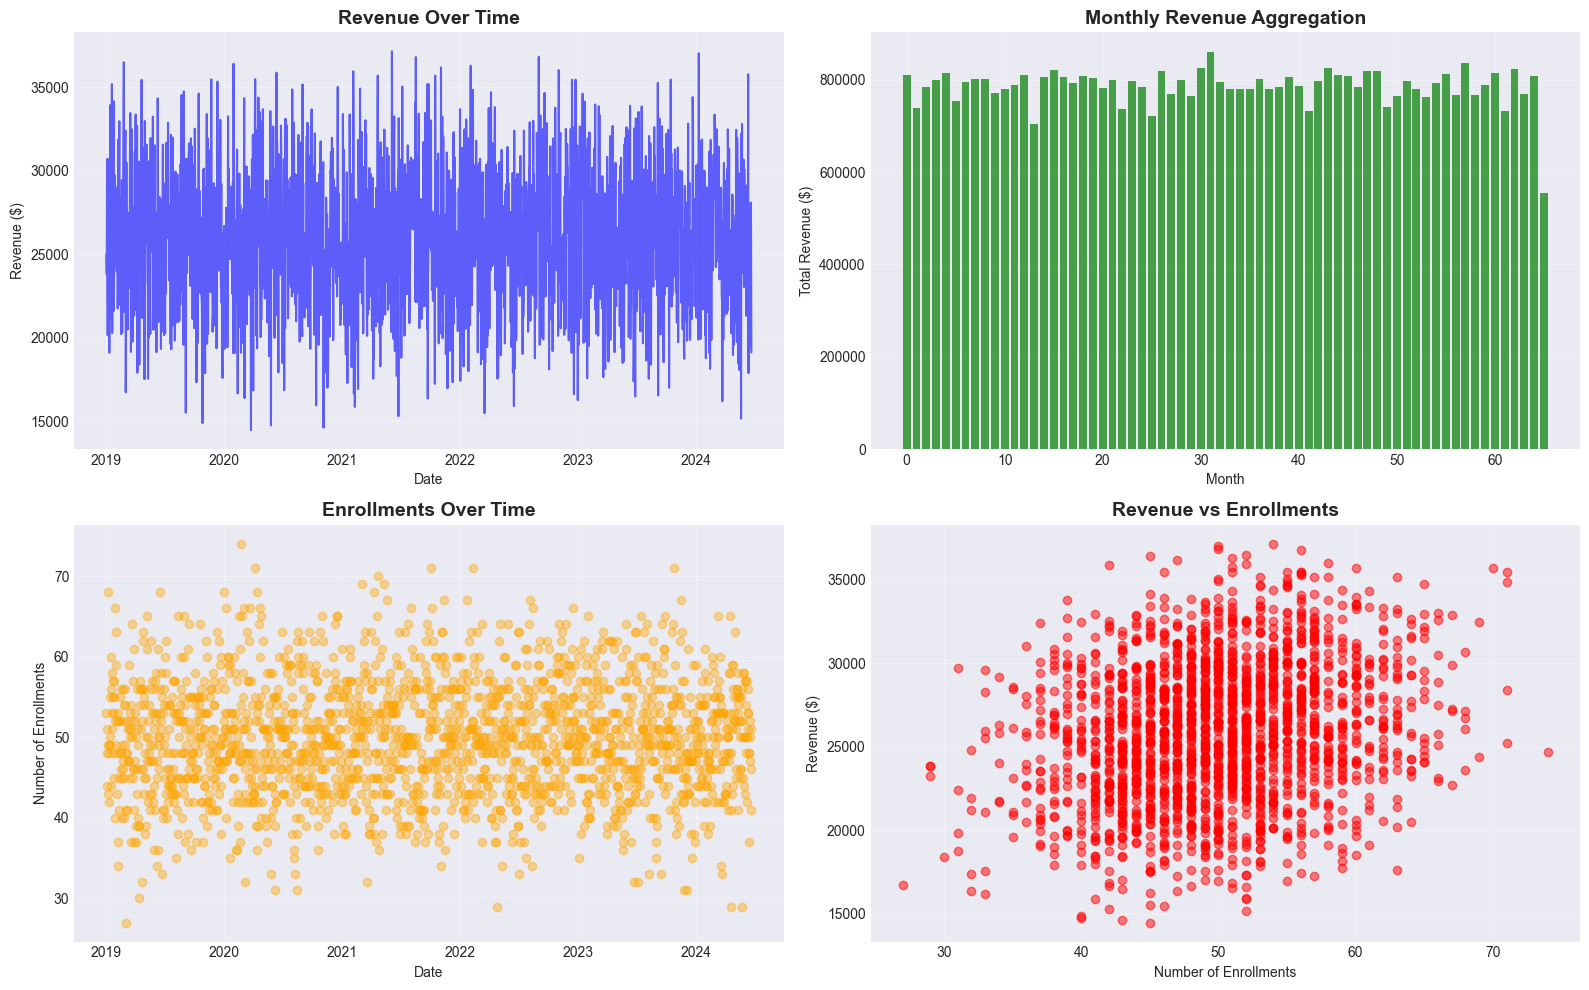


Correlation between Revenue and Enrollments: 0.233


In [13]:
# Revenue over time
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Revenue over time
axes[0, 0].plot(df['Date'], df['Revenue'], alpha=0.6, color='blue')
axes[0, 0].set_title('Revenue Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Revenue ($)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Monthly revenue aggregation
df['Month'] = df['Date'].dt.to_period('M')
monthly_revenue = df.groupby('Month')['Revenue'].sum()
axes[0, 1].bar(range(len(monthly_revenue)), monthly_revenue.values, color='green', alpha=0.7)
axes[0, 1].set_title('Monthly Revenue Aggregation', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Total Revenue ($)')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Enrollments over time
axes[1, 0].scatter(df['Date'], df['Number of Enrollments'], alpha=0.4, color='orange')
axes[1, 0].set_title('Enrollments Over Time', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Number of Enrollments')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Revenue vs Enrollments correlation
axes[1, 1].scatter(df['Number of Enrollments'], df['Revenue'], alpha=0.5, color='red')
axes[1, 1].set_title('Revenue vs Enrollments', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Enrollments')
axes[1, 1].set_ylabel('Revenue ($)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCorrelation between Revenue and Enrollments: {df['Revenue'].corr(df['Number of Enrollments']):.3f}")

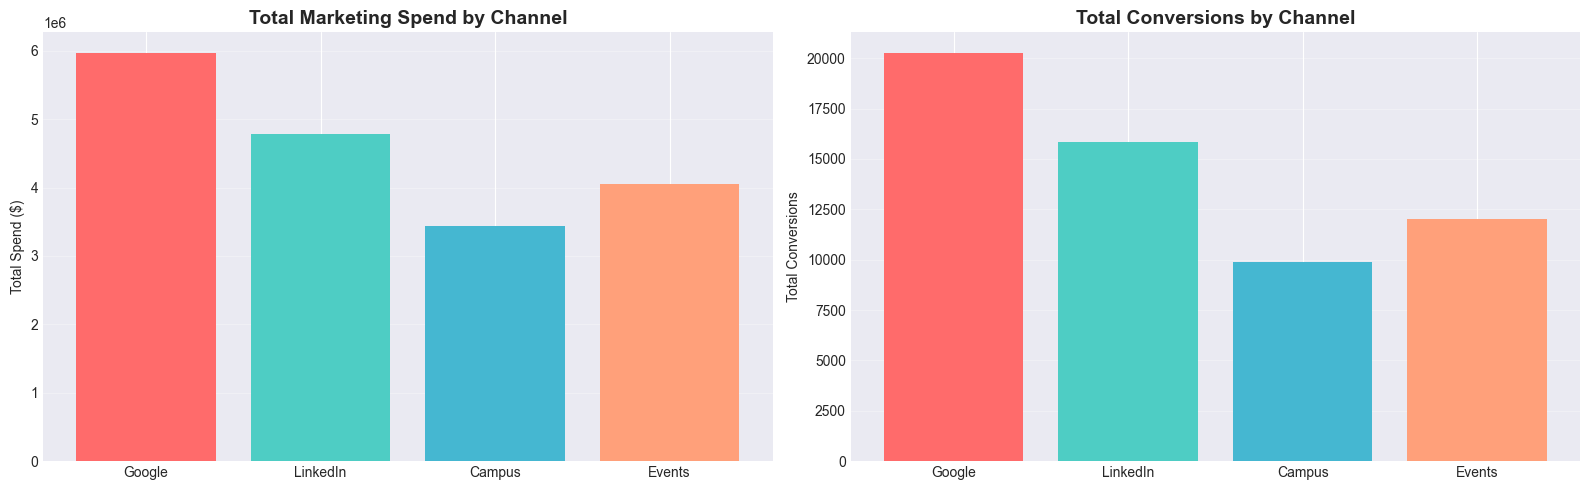


MARKETING CHANNEL ROI ANALYSIS

Google:
  Total Spend: $5,971,122.99
  Total Conversions: 20273
  Cost per Conversion: $294.54

LinkedIn:
  Total Spend: $4,776,223.35
  Total Conversions: 15867
  Cost per Conversion: $301.02

Campus:
  Total Spend: $3,439,198.61
  Total Conversions: 9887
  Cost per Conversion: $347.85

Events:
  Total Spend: $4,051,545.70
  Total Conversions: 11998
  Cost per Conversion: $337.69


In [14]:
# Marketing spend analysis
marketing_channels = ['Google', 'LinkedIn', 'Campus', 'Events']
marketing_spends = [df[f'Marketing Spend ({ch})'].sum() for ch in marketing_channels]
conversions = [df[f'Conversions ({ch})'].sum() for ch in marketing_channels]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Marketing spend by channel
axes[0].bar(marketing_channels, marketing_spends, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[0].set_title('Total Marketing Spend by Channel', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Total Spend ($)')
axes[0].grid(True, alpha=0.3, axis='y')

# Conversions by channel
axes[1].bar(marketing_channels, conversions, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[1].set_title('Total Conversions by Channel', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Total Conversions')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate ROI for each channel
print("\n" + "=" * 80)
print("MARKETING CHANNEL ROI ANALYSIS")
print("=" * 80)
for channel in marketing_channels:
    total_spend = df[f'Marketing Spend ({channel})'].sum()
    total_conversions = df[f'Conversions ({channel})'].sum()
    cost_per_conversion = total_spend / total_conversions if total_conversions > 0 else 0
    print(f"\n{channel}:")
    print(f"  Total Spend: ${total_spend:,.2f}")
    print(f"  Total Conversions: {total_conversions}")
    print(f"  Cost per Conversion: ${cost_per_conversion:.2f}")

In [15]:
# Create a copy for feature engineering
df_features = df.copy()

# Date-based features
df_features['Year'] = df_features['Date'].dt.year
df_features['Month'] = df_features['Date'].dt.month
df_features['Quarter'] = df_features['Date'].dt.quarter
df_features['DayOfWeek'] = df_features['Date'].dt.dayofweek
df_features['DayOfYear'] = df_features['Date'].dt.dayofyear
df_features['WeekOfYear'] = df_features['Date'].dt.isocalendar().week

# Total marketing spend
df_features['Total Marketing Spend'] = (
    df_features['Marketing Spend (Google)'] + 
    df_features['Marketing Spend (LinkedIn)'] + 
    df_features['Marketing Spend (Campus)'] + 
    df_features['Marketing Spend (Events)']
)

# Total conversions
df_features['Total Conversions'] = (
    df_features['Conversions (Google)'] + 
    df_features['Conversions (LinkedIn)'] + 
    df_features['Conversions (Campus)'] + 
    df_features['Conversions (Events)']
)

# Total leads
df_features['Total Leads'] = (
    df_features['Leads Generated (Google)'] + 
    df_features['Leads Generated (LinkedIn)'] + 
    df_features['Leads Generated (Campus)'] + 
    df_features['Leads Generated (Events)']
)

# Conversion rate
df_features['Conversion Rate'] = df_features['Total Conversions'] / df_features['Total Leads']
df_features['Conversion Rate'] = df_features['Conversion Rate'].fillna(0)

# Total costs
df_features['Total Costs'] = (
    df_features['Operational Costs'] + 
    df_features['Fixed Costs'] + 
    df_features['Variable Costs']
)

# Profit
df_features['Profit'] = df_features['Revenue'] - df_features['Total Costs']

# Marketing efficiency (Revenue per marketing dollar)
df_features['Marketing Efficiency'] = df_features['Revenue'] / df_features['Total Marketing Spend']

# Enrollment rate (if we assume leads convert to enrollments)
df_features['Enrollment Rate'] = df_features['Number of Enrollments'] / df_features['Total Leads']
df_features['Enrollment Rate'] = df_features['Enrollment Rate'].fillna(0)

# Lag features (previous period data)
df_features['Revenue_Lag1'] = df_features['Revenue'].shift(1)
df_features['Revenue_Lag7'] = df_features['Revenue'].shift(7)
df_features['Revenue_Lag30'] = df_features['Revenue'].shift(30)
df_features['Enrollments_Lag1'] = df_features['Number of Enrollments'].shift(1)
df_features['Enrollments_Lag7'] = df_features['Number of Enrollments'].shift(7)

# Rolling averages
df_features['Revenue_MA7'] = df_features['Revenue'].rolling(window=7, min_periods=1).mean()
df_features['Revenue_MA30'] = df_features['Revenue'].rolling(window=30, min_periods=1).mean()
df_features['Enrollments_MA7'] = df_features['Number of Enrollments'].rolling(window=7, min_periods=1).mean()

# Encode categorical variables
le_seasonal = LabelEncoder()
df_features['Seasonal_Encoded'] = le_seasonal.fit_transform(df_features['Seasonal Trends'])

le_payment = LabelEncoder()
df_features['Payment_Encoded'] = le_payment.fit_transform(df_features['Payment Terms'])

# Fill NaN values from lag features
df_features = df_features.fillna(method='bfill').fillna(0)

print("✅ Feature engineering completed!")
print(f"\nNew feature count: {df_features.shape[1]}")
print("\nNew features created:")
new_features = [col for col in df_features.columns if col not in df.columns]
for feature in new_features:
    print(f"  - {feature}")

✅ Feature engineering completed!

New feature count: 50

New features created:
  - Year
  - Quarter
  - DayOfWeek
  - DayOfYear
  - WeekOfYear
  - Total Marketing Spend
  - Total Conversions
  - Total Leads
  - Conversion Rate
  - Total Costs
  - Profit
  - Marketing Efficiency
  - Enrollment Rate
  - Revenue_Lag1
  - Revenue_Lag7
  - Revenue_Lag30
  - Enrollments_Lag1
  - Enrollments_Lag7
  - Revenue_MA7
  - Revenue_MA30
  - Enrollments_MA7
  - Seasonal_Encoded
  - Payment_Encoded


In [16]:
# Prepare features for revenue prediction
feature_columns = [
    'Number of Enrollments',
    'Total Marketing Spend',
    'Marketing Spend (Google)',
    'Marketing Spend (LinkedIn)',
    'Marketing Spend (Campus)',
    'Marketing Spend (Events)',
    'Operational Costs',
    'Retention Rates',
    'Total Conversions',
    'Total Leads',
    'Conversion Rate',
    'Fixed Costs',
    'Variable Costs',
    'Month',
    'Quarter',
    'DayOfWeek',
    'Seasonal_Encoded',
    'Payment_Encoded',
    'Revenue_Lag1',
    'Revenue_Lag7',
    'Revenue_Lag30',
    'Enrollments_Lag1',
    'Enrollments_Lag7',
    'Revenue_MA7',
    'Revenue_MA30',
    'Enrollments_MA7',
    'Marketing Efficiency',
    'Enrollment Rate'
]

X = df_features[feature_columns]
y = df_features['Revenue']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Data prepared for Task 1: Revenue Forecasting")

Training set size: 1600
Test set size: 400
Number of features: 28

✅ Data prepared for Task 1: Revenue Forecasting


Checking for NaN or Inf values:
ds                 0
y                  0
enrollments        0
marketing_spend    0
retention          0
dtype: int64
ds                 0
y                  0
enrollments        0
marketing_spend    0
retention          0
dtype: int64

Training SARIMAX Model...


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



SARIMAX MODEL PERFORMANCE
Mean Absolute Error: $981.24
Root Mean Squared Error: $1,218.18
R² Score: 0.9127


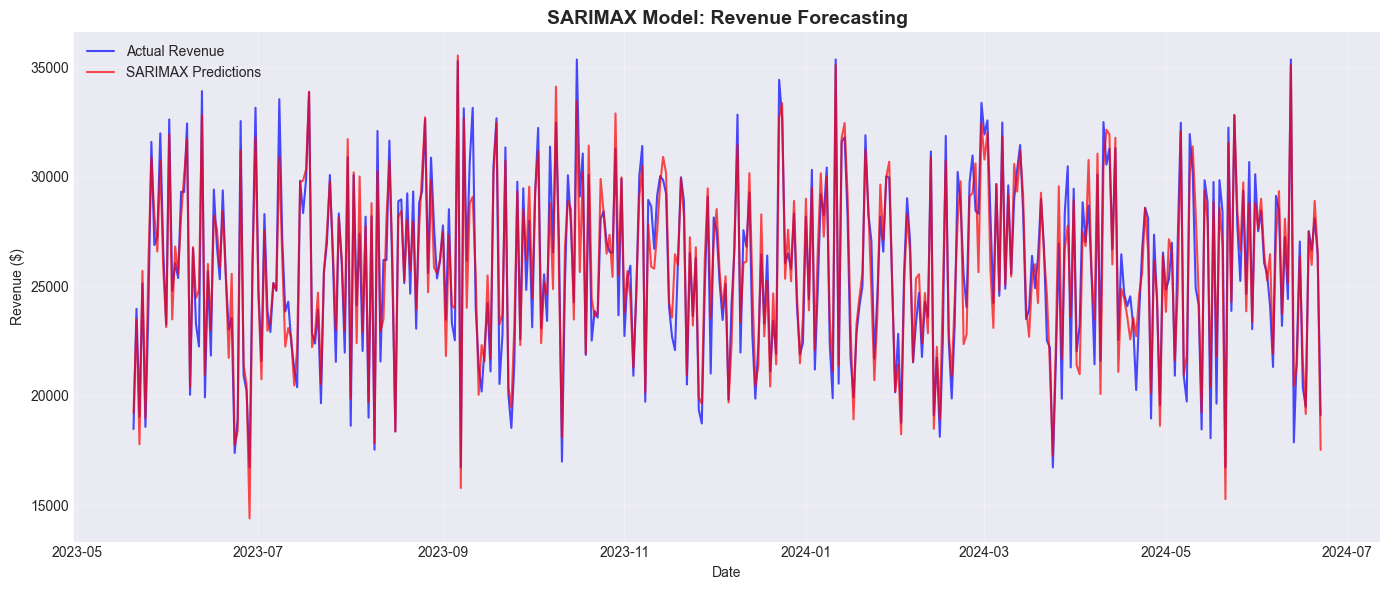


✅ SARIMAX model trained successfully!


In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare data for SARIMAX (similar to Prophet)
sarimax_df = df_features[['Date', 'Revenue']].copy()
sarimax_df.columns = ['ds', 'y']
sarimax_df['enrollments'] = df_features['Number of Enrollments'].values
sarimax_df['marketing_spend'] = df_features['Total Marketing Spend'].values
sarimax_df['retention'] = df_features['Retention Rates'].values

# Data validation
print("Checking for NaN or Inf values:")
print(sarimax_df.isnull().sum())
print(sarimax_df.isin([np.inf, -np.inf]).sum())
sarimax_df = sarimax_df.fillna(0)  # Handle NaN values
sarimax_df = sarimax_df.replace([np.inf, -np.inf], 0)  # Handle Inf values

# Ensure 'ds' is in datetime format and set as index
sarimax_df['ds'] = pd.to_datetime(sarimax_df['ds'])
sarimax_df.set_index('ds', inplace=True)

# Scale exogenous variables
scaler = StandardScaler()
exog_columns = ['enrollments', 'marketing_spend', 'retention']
sarimax_df[exog_columns] = scaler.fit_transform(sarimax_df[exog_columns])

# Clip extreme values in 'y' to stabilize training
sarimax_df['y'] = sarimax_df['y'].clip(lower=sarimax_df['y'].quantile(0.01), upper=sarimax_df['y'].quantile(0.99))

# Split for SARIMAX
train_size = int(len(sarimax_df) * 0.8)
sarimax_train = sarimax_df[:train_size]
sarimax_test = sarimax_df[train_size:]

# Initialize and train SARIMAX model
print("\nTraining SARIMAX Model...")
# Define SARIMAX model: (p,d,q) = (1,1,1), seasonal (P,D,Q,s) = (1,1,1,7) for weekly seasonality
sarimax_model = SARIMAX(
    sarimax_train['y'],
    exog=sarimax_train[exog_columns],
    order=(1, 1, 1),  # ARIMA parameters: (p,d,q)
    seasonal_order=(1, 1, 1, 7)  # Seasonal parameters: (P,D,Q,s), s=7 for weekly
)

# Fit model
try:
    sarimax_results = sarimax_model.fit(disp=False)
except Exception as e:
    print(f"SARIMAX fitting failed: {e}")
    print("Falling back to simpler ARIMA model without seasonality...")
    sarimax_model = SARIMAX(
        sarimax_train['y'],
        exog=sarimax_train[exog_columns],
        order=(1, 1, 1)  # Simple ARIMA
    )
    sarimax_results = sarimax_model.fit(disp=False)

# Make predictions
sarimax_forecast = sarimax_results.forecast(steps=len(sarimax_test), exog=sarimax_test[exog_columns])
sarimax_predictions = sarimax_forecast.values

# Evaluate SARIMAX model
sarimax_mae = mean_absolute_error(sarimax_test['y'], sarimax_predictions)
sarimax_rmse = np.sqrt(mean_squared_error(sarimax_test['y'], sarimax_predictions))
sarimax_r2 = r2_score(sarimax_test['y'], sarimax_predictions)

print("\n" + "=" * 80)
print("SARIMAX MODEL PERFORMANCE")
print("=" * 80)
print(f"Mean Absolute Error: ${sarimax_mae:,.2f}")
print(f"Root Mean Squared Error: ${sarimax_rmse:,.2f}")
print(f"R² Score: {sarimax_r2:.4f}")

# Visualize SARIMAX predictions
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(sarimax_test.index, sarimax_test['y'], label='Actual Revenue', color='blue', alpha=0.7)
ax.plot(sarimax_test.index, sarimax_predictions, label='SARIMAX Predictions', color='red', alpha=0.7)
ax.set_title('SARIMAX Model: Revenue Forecasting', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue ($)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ SARIMAX model trained successfully!")

Training XGBoost Model...

XGBOOST MODEL PERFORMANCE
Mean Absolute Error: $378.54
Root Mean Squared Error: $539.65
R² Score: 0.9834

TOP 10 IMPORTANT FEATURES
                       Feature  Importance
1        Total Marketing Spend    0.475436
2     Marketing Spend (Google)    0.164324
3   Marketing Spend (LinkedIn)    0.077042
5     Marketing Spend (Events)    0.064674
26        Marketing Efficiency    0.061608
4     Marketing Spend (Campus)    0.033442
23                 Revenue_MA7    0.022692
27             Enrollment Rate    0.016531
0        Number of Enrollments    0.012707
25             Enrollments_MA7    0.011526


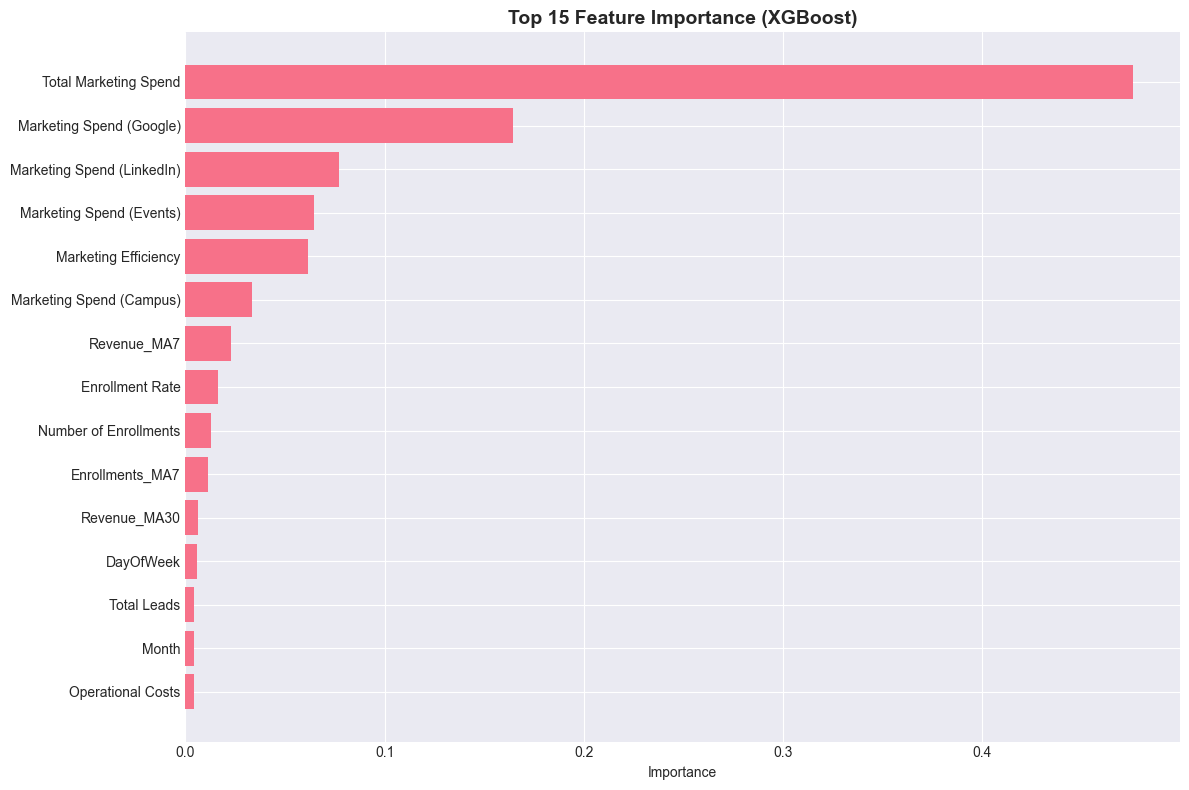


✅ XGBoost model trained successfully!


In [23]:
# Train XGBoost model
print("Training XGBoost Model...")

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# Predictions
xgb_train_pred = xgb_model.predict(X_train_scaled)
xgb_test_pred = xgb_model.predict(X_test_scaled)

# Evaluate XGBoost
xgb_mae = mean_absolute_error(y_test, xgb_test_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))
xgb_r2 = r2_score(y_test, xgb_test_pred)

print("\n" + "=" * 80)
print("XGBOOST MODEL PERFORMANCE")
print("=" * 80)
print(f"Mean Absolute Error: ${xgb_mae:,.2f}")
print(f"Root Mean Squared Error: ${xgb_rmse:,.2f}")
print(f"R² Score: {xgb_r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "=" * 80)
print("TOP 10 IMPORTANT FEATURES")
print("=" * 80)
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'].head(15), feature_importance['Importance'].head(15))
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n✅ XGBoost model trained successfully!")

In [24]:
# Train Random Forest model
print("Training Random Forest Model...")

rf_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# Predictions
rf_test_pred = rf_model.predict(X_test_scaled)

# Evaluate Random Forest
rf_mae = mean_absolute_error(y_test, rf_test_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))
rf_r2 = r2_score(y_test, rf_test_pred)

print("\n" + "=" * 80)
print("RANDOM FOREST MODEL PERFORMANCE")
print("=" * 80)
print(f"Mean Absolute Error: ${rf_mae:,.2f}")
print(f"Root Mean Squared Error: ${rf_rmse:,.2f}")
print(f"R² Score: {rf_r2:.4f}")

print("\n✅ Random Forest model trained successfully!")

Training Random Forest Model...

RANDOM FOREST MODEL PERFORMANCE
Mean Absolute Error: $212.64
Root Mean Squared Error: $422.48
R² Score: 0.9898

✅ Random Forest model trained successfully!


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Align predictions
min_len = len(sarimax_predictions)
xgb_aligned = xgb_test_pred[:min_len]
rf_aligned = rf_test_pred[:min_len]

# Prepare stacking input (columns = model predictions)
stack_input = np.vstack([sarimax_predictions, xgb_aligned, rf_aligned]).T

# Train linear regressor as meta-model
stack_model = LinearRegression()
stack_model.fit(stack_input, sarimax_test['y'])

# Get ensemble predictions
ensemble_pred = stack_model.predict(stack_input)

# Evaluate ensemble
ensemble_mae = mean_absolute_error(sarimax_test['y'], ensemble_pred)
ensemble_rmse = np.sqrt(mean_squared_error(sarimax_test['y'], ensemble_pred))
ensemble_r2 = r2_score(sarimax_test['y'], ensemble_pred)

print("\n" + "=" * 80)
print("STACKED ENSEMBLE MODEL PERFORMANCE")
print("=" * 80)
print(f"Mean Absolute Error: ${ensemble_mae:,.2f}")
print(f"Root Mean Squared Error: ${ensemble_rmse:,.2f}")
print(f"R² Score: {ensemble_r2:.4f}")


STACKED ENSEMBLE MODEL PERFORMANCE
Mean Absolute Error: $977.71
Root Mean Squared Error: $1,217.14
R² Score: 0.9129



MODEL COMPARISON
           Model         MAE        RMSE  R² Score
         SARIMAX  981.237042 1218.182277  0.912745
         XGBoost 4626.773455 5798.114554  0.983430
   Random Forest 4667.259330 5845.419135  0.989845
Stacked Ensemble  977.714547 1217.143521  0.912894


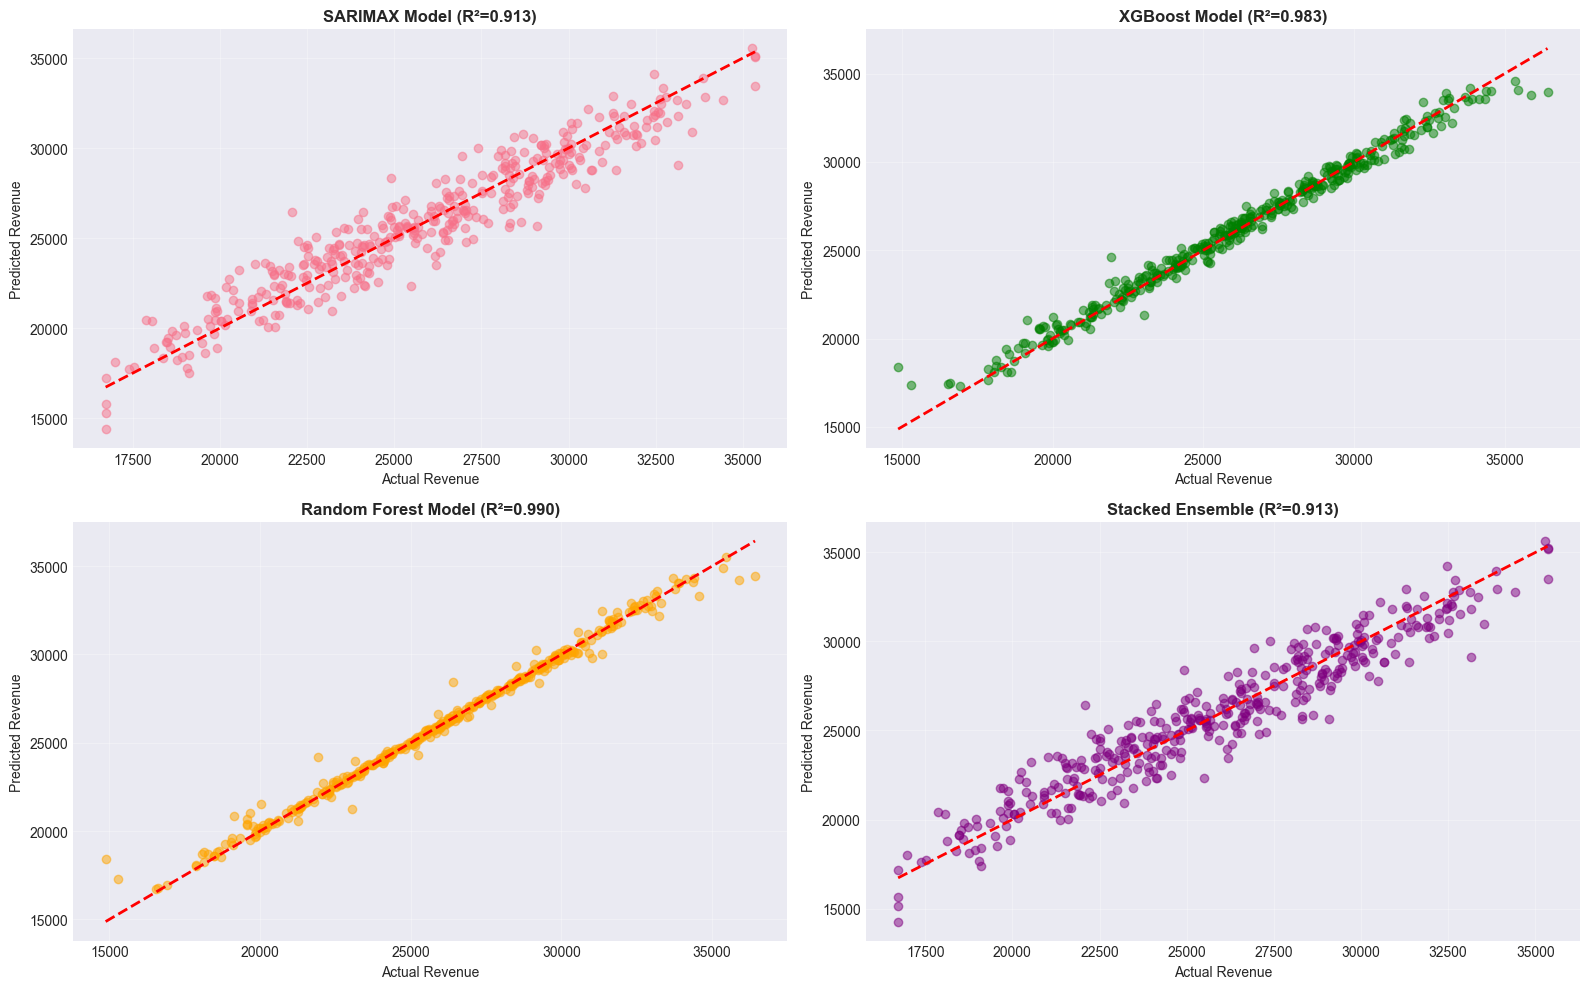


✅ Stacked ensemble visualizations created successfully!


In [32]:
# Comparison table
comparison_df = pd.DataFrame({
    'Model': ['SARIMAX', 'XGBoost', 'Random Forest', 'Stacked Ensemble'],
    'MAE': [sarimax_mae, xgb_mae, rf_mae, ensemble_mae],
    'RMSE': [sarimax_rmse, xgb_rmse, rf_rmse, ensemble_rmse],
    'R² Score': [sarimax_r2, xgb_r2, rf_r2, ensemble_r2]
})

print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# SARIMAX predictions
axes[0, 0].scatter(sarimax_test['y'], sarimax_predictions, alpha=0.5)
axes[0, 0].plot([sarimax_test['y'].min(), sarimax_test['y'].max()],
                [sarimax_test['y'].min(), sarimax_test['y'].max()], 'r--', lw=2)
axes[0, 0].set_title(f'SARIMAX Model (R²={sarimax_r2:.3f})', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Actual Revenue')
axes[0, 0].set_ylabel('Predicted Revenue')
axes[0, 0].grid(True, alpha=0.3)

# XGBoost predictions
axes[0, 1].scatter(y_test, xgb_test_pred, alpha=0.5, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_title(f'XGBoost Model (R²={xgb_r2:.3f})', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Actual Revenue')
axes[0, 1].set_ylabel('Predicted Revenue')
axes[0, 1].grid(True, alpha=0.3)

# Random Forest predictions
axes[1, 0].scatter(y_test, rf_test_pred, alpha=0.5, color='orange')
axes[1, 0].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_title(f'Random Forest Model (R²={rf_r2:.3f})', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Actual Revenue')
axes[1, 0].set_ylabel('Predicted Revenue')
axes[1, 0].grid(True, alpha=0.3)

# Stacked Ensemble predictions
axes[1, 1].scatter(sarimax_test['y'], ensemble_pred, alpha=0.5, color='purple')
axes[1, 1].plot([sarimax_test['y'].min(), sarimax_test['y'].max()],
                [sarimax_test['y'].min(), sarimax_test['y'].max()], 'r--', lw=2)
axes[1, 1].set_title(f'Stacked Ensemble (R²={ensemble_r2:.3f})', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Actual Revenue')
axes[1, 1].set_ylabel('Predicted Revenue')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Stacked ensemble visualizations created successfully!")

In [33]:
# Use forecasted revenue as input for cash flow prediction
# Add forecasted revenue to the features dataframe
df_cashflow = df_features.copy()

# Create cash flow target variable
# Cash Flow = Revenue - Total Costs - Liabilities
df_cashflow['Cash Flow'] = (
    df_cashflow['Revenue'] - 
    df_cashflow['Total Costs'] - 
    df_cashflow['Liabilities']
)

# Create liquidity requirement categories
# Positive cash flow = Low liquidity need
# Small negative = Medium liquidity need
# Large negative = High liquidity need
def categorize_liquidity(cash_flow):
    if cash_flow > 5000:
        return 'Low'  # Surplus, low liquidity need
    elif cash_flow > 0:
        return 'Medium'  # Small surplus, medium need
    else:
        return 'High'  # Deficit, high liquidity need

df_cashflow['Liquidity Requirement'] = df_cashflow['Cash Flow'].apply(categorize_liquidity)

# Prepare features for cash flow prediction
cashflow_features = [
    'Revenue',  # Will use forecasted revenue in production
    'Total Costs',
    'Operational Costs',
    'Fixed Costs',
    'Variable Costs',
    'Liabilities',
    'Total Marketing Spend',
    'Number of Enrollments',
    'Retention Rates',
    'Payment_Encoded',
    'Month',
    'Quarter',
    'Profit',
    'Revenue_MA7',
    'Revenue_MA30'
]

X_cashflow = df_cashflow[cashflow_features]
y_cashflow_regression = df_cashflow['Cash Flow']
y_cashflow_classification = df_cashflow['Liquidity Requirement']

# Split data
X_cf_train, X_cf_test, y_cf_train, y_cf_test = train_test_split(
    X_cashflow, y_cashflow_regression, test_size=0.2, random_state=42
)

# For classification
_, _, y_cf_class_train, y_cf_class_test = train_test_split(
    X_cashflow, y_cashflow_classification, test_size=0.2, random_state=42
)

# Scale features
scaler_cashflow = StandardScaler()
X_cf_train_scaled = scaler_cashflow.fit_transform(X_cf_train)
X_cf_test_scaled = scaler_cashflow.transform(X_cf_test)

print(f"Cash Flow Training set: {X_cf_train.shape[0]}")
print(f"Cash Flow Test set: {X_cf_test.shape[0]}")
print(f"\nLiquidity Requirement Distribution:")
print(df_cashflow['Liquidity Requirement'].value_counts())

print("\n✅ Data prepared for Task 2: Cash Flow Prediction")

Cash Flow Training set: 1600
Cash Flow Test set: 400

Liquidity Requirement Distribution:
Liquidity Requirement
Low       1854
Medium     138
High         8
Name: count, dtype: int64

✅ Data prepared for Task 2: Cash Flow Prediction


Training XGBoost for Cash Flow Regression...

CASH FLOW REGRESSION MODEL (XGBoost)
Mean Absolute Error: $153.19
Root Mean Squared Error: $202.55
R² Score: 0.9982


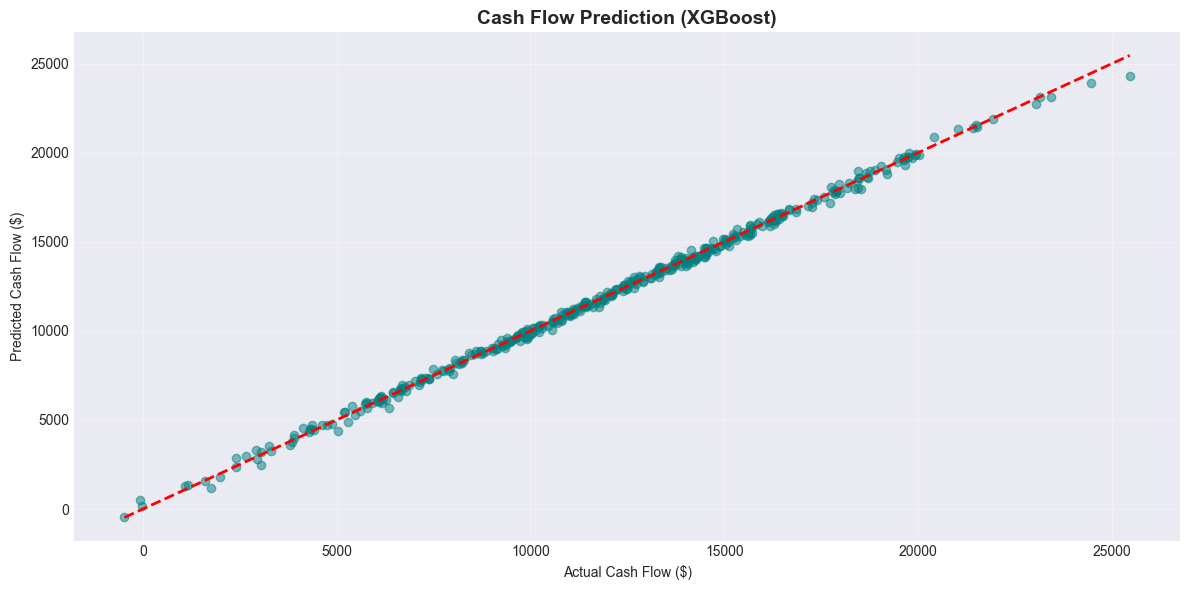


✅ Cash Flow regression model trained!


In [34]:
# Train XGBoost for cash flow prediction
print("Training XGBoost for Cash Flow Regression...")

xgb_cashflow = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_cashflow.fit(X_cf_train_scaled, y_cf_train)

# Predictions
cf_xgb_pred = xgb_cashflow.predict(X_cf_test_scaled)

# Evaluate
cf_xgb_mae = mean_absolute_error(y_cf_test, cf_xgb_pred)
cf_xgb_rmse = np.sqrt(mean_squared_error(y_cf_test, cf_xgb_pred))
cf_xgb_r2 = r2_score(y_cf_test, cf_xgb_pred)

print("\n" + "=" * 80)
print("CASH FLOW REGRESSION MODEL (XGBoost)")
print("=" * 80)
print(f"Mean Absolute Error: ${cf_xgb_mae:,.2f}")
print(f"Root Mean Squared Error: ${cf_xgb_rmse:,.2f}")
print(f"R² Score: {cf_xgb_r2:.4f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_cf_test, cf_xgb_pred, alpha=0.5, color='teal')
plt.plot([y_cf_test.min(), y_cf_test.max()], 
         [y_cf_test.min(), y_cf_test.max()], 'r--', lw=2)
plt.xlabel('Actual Cash Flow ($)')
plt.ylabel('Predicted Cash Flow ($)')
plt.title('Cash Flow Prediction (XGBoost)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Cash Flow regression model trained!")

Training Random Forest for Liquidity Classification...


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000002811DEC3A60>



LIQUIDITY REQUIREMENT CLASSIFICATION (Random Forest)
Accuracy: 0.9625

Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         3
         Low       0.98      0.99      0.98       370
      Medium       0.75      0.67      0.71        27

    accuracy                           0.96       400
   macro avg       0.58      0.55      0.56       400
weighted avg       0.95      0.96      0.96       400



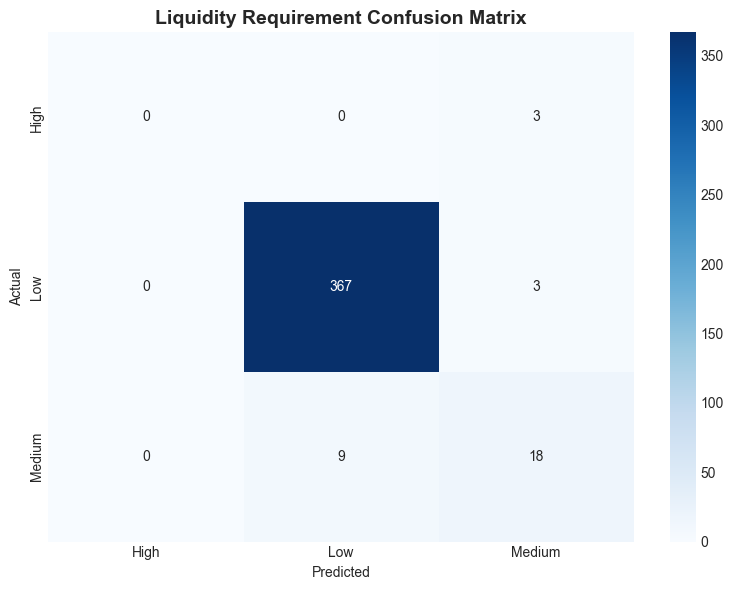


✅ Liquidity classification model trained!


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train Random Forest classifier for liquidity requirements
print("Training Random Forest for Liquidity Classification...")

rf_liquidity = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_liquidity.fit(X_cf_train_scaled, y_cf_class_train)

# Predictions
liq_pred = rf_liquidity.predict(X_cf_test_scaled)
liq_pred_proba = rf_liquidity.predict_proba(X_cf_test_scaled)

# Evaluate
liq_accuracy = accuracy_score(y_cf_class_test, liq_pred)

print("\n" + "=" * 80)
print("LIQUIDITY REQUIREMENT CLASSIFICATION (Random Forest)")
print("=" * 80)
print(f"Accuracy: {liq_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_cf_class_test, liq_pred))

# Confusion matrix
cm = confusion_matrix(y_cf_class_test, liq_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['High', 'Low', 'Medium'],
            yticklabels=['High', 'Low', 'Medium'])
plt.title('Liquidity Requirement Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\n✅ Liquidity classification model trained!")

In [37]:
import os

# Create models directory
os.makedirs('models', exist_ok=True)

# Save Prophet model
with open('models/sarimax_revenue_model.pkl', 'wb') as f:
    pickle.dump(sarimax_model, f)

# Save XGBoost models
joblib.dump(xgb_model, 'models/xgboost_revenue_model.pkl')
joblib.dump(xgb_cashflow, 'models/xgboost_cashflow_model.pkl')

# Save Random Forest models
joblib.dump(rf_model, 'models/rf_revenue_model.pkl')
joblib.dump(rf_liquidity, 'models/rf_liquidity_model.pkl')

# Save scalers
joblib.dump(scaler, 'models/revenue_scaler.pkl')
joblib.dump(scaler_cashflow, 'models/cashflow_scaler.pkl')

# Save label encoders
joblib.dump(le_seasonal, 'models/seasonal_encoder.pkl')
joblib.dump(le_payment, 'models/payment_encoder.pkl')

# Save feature columns
with open('models/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)

with open('models/cashflow_features.pkl', 'wb') as f:
    pickle.dump(cashflow_features, f)

# Save the trained stack (meta) model
joblib.dump(stack_model, 'models/stacked_ensemble_model.pkl')

# Optionally, store model names or info for reference
ensemble_info = {
    'base_models': ['SARIMAX', 'XGBoost', 'RandomForest'],
    'meta_model': 'LinearRegression',
    'input_order': ['sarimax_predictions', 'xgb_predictions', 'rf_predictions']
}

joblib.dump(ensemble_info, 'models/ensemble_info.pkl')

print("✅ All models saved successfully!")

✅ All models saved successfully!


In [38]:
# Create metadata file for Streamlit app
metadata = {
    'model_info': {
        'revenue_forecasting': {
            'prophet': {
                'mae': float(sarimax_mae),
                'rmse': float(sarimax_rmse),
                'r2': float(sarimax_r2)
            },
            'xgboost': {
                'mae': float(xgb_mae),
                'rmse': float(xgb_rmse),
                'r2': float(xgb_r2)
            },
            'random_forest': {
                'mae': float(rf_mae),
                'rmse': float(rf_rmse),
                'r2': float(rf_r2)
            },
            'ensemble': {
                'mae': float(ensemble_mae),
                'rmse': float(ensemble_rmse),
                'r2': float(ensemble_r2)
            }
        },
        'cashflow_prediction': {
            'xgboost': {
                'mae': float(cf_xgb_mae),
                'rmse': float(cf_xgb_rmse),
                'r2': float(cf_xgb_r2)
            },
            'liquidity_classifier': {
                'accuracy': float(liq_accuracy)
            }
        }
    },
    'feature_columns': feature_columns,
    'cashflow_features': cashflow_features,
    'training_date': str(datetime.now()),
    'data_range': {
        'start': str(df['Date'].min()),
        'end': str(df['Date'].max()),
        'total_records': len(df)
    }
}

# Save metadata as JSON
import json
with open('models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("✅ Model metadata saved!")
print("\nMetadata Summary:")
print(json.dumps(metadata['model_info'], indent=2))

✅ Model metadata saved!

Metadata Summary:
{
  "revenue_forecasting": {
    "prophet": {
      "mae": 981.2370422709708,
      "rmse": 1218.1822770598378,
      "r2": 0.9127449401626678
    },
    "xgboost": {
      "mae": 4626.773455148437,
      "rmse": 5798.114554311338,
      "r2": 0.98343
    },
    "random_forest": {
      "mae": 4667.259330426465,
      "rmse": 5845.419135458423,
      "r2": 0.989845
    },
    "ensemble": {
      "mae": 977.714546804819,
      "rmse": 1217.143520732711,
      "r2": 0.9128936832592502
    }
  },
  "cashflow_prediction": {
    "xgboost": {
      "mae": 153.18831299133302,
      "rmse": 202.552668752192,
      "r2": 0.9981548348648727
    },
    "liquidity_classifier": {
      "accuracy": 0.9625
    }
  }
}
